# Fire or No Fire?

In this miniproject you will attempt to identify fires from aerial vehicle cameras. 

From the dataset creators, "Wildfires are one of the deadliest and dangerous natural disasters in the world. Wildfires burn millions of forests and they put many lives of humans and animals in danger. Predicting fire behavior can help firefighters to have better fire management and scheduling for future incidents and also it reduces the life risks for the firefighters. Recent advance in aerial images shows that they can be beneficial in wildfire studies. Among different methods and technologies for aerial images, Unmanned Aerial Vehicles (UAVs) and drones are beneficial to collect information regarding the fire."

## Dataset description

The data was obtained from flying an aerial vehicle over an area during a period of prescribed burning. The original data is in the form of a video, whilst here that video has been resized and split into individual frames. Given the nature of this dataset there is a lot of similarity between some of the images (e.g. neighbouring frames in the video). For further information about this dataset please see the [arxiv paper](https://arxiv.org/pdf/2012.14036.pdf)

## Machine learning tasks
1. Develop a machine learning classifier that can accurately perform the binary classification Fire vs No Fire
2. Develop a machine learning classifier that can accurately perform the ternary classification Fire vs No Fire vs Lake

## Optional extension tasks
1. Using your fire dataset develop a method of labeling which pixels are associated with the fire (using the segmentation data set)
2. Develop a method that label which pixels in the Fire vs No Fire dataset have fire in them.

### Things to think about
* What kind of data processing is appropriate?
* Should you split your training sample further to give a validation sample?
* What is an appropriate cost or loss function?
* Should you consider data augementation?
* Do you need to balance your data set in some way
* One of the optional tasks is based on image segmentation which most relies on network structures similar to autoencoders (but these days are often referred to as u-net structures).
* For the optional tasks you might take inspiration from the [Tensorflow Image Segmentation Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)

In [1]:
#Import standard libraries and imageio to read in the images
import imageio.v3 as imageio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
# Additional libraries
import re
from PIL import Image
import shutil

# Tensorflow & Keras libs
import tensorflow as tf

# Setting the number of inter-op threads
tf.config.threading.set_inter_op_parallelism_threads(64)

# Setting the number of intra-op threads
tf.config.threading.set_intra_op_parallelism_threads(64)

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator


___
<h1>Using CNNs To Accurately Identify Fires | SN: 21006211</h1>

<h2>1.0: Determination of Dataset Sizes</h2>

By using my computer's file viewer, I was able to manually determine the number of images (data) in each data subset classification:

No of images in files:
- Training: Fire - 25018
- Training: No_fire - 11847 Lake Images, 2510 Forest Images (TOTAL: 14357)
- Test: Fire -  5137
- Test: No_fire - 3480

However, given that this is a computing module, code will be used to verify that these values are correct:

In [3]:
# Determining the number of images (data) in each training subset
train_fire_count = len([name for name in os.listdir('Training/Fire/') if os.path.isfile(os.path.join('Training/Fire/', name))])
train_no_fire_count = len([name for name in os.listdir('Training/No_Fire/') if os.path.isfile(os.path.join('Training/No_Fire/', name))])

# Determining the number of images (data) in each test subset
test_fire_count = len([name for name in os.listdir('Test/Fire/') if os.path.isfile(os.path.join('Test/Fire/', name))])
test_nofire_count = len([name for name in os.listdir('Test/No_Fire/') if os.path.isfile(os.path.join('Test/No_Fire/', name))])

# Creating a dictionary that stores the number of images in each dataset
no_dataset_imgs = {
      'Classification Subset': ['Training: Fire', 'Train: No Fire + Lake', 'Test: Fire', 'Test: No Fire'],
      'Number of Images': [train_fire_count,train_no_fire_count,test_fire_count,test_nofire_count]
}

# Displaying the info in the dict above as a table of data via pandas
df = pd.DataFrame(no_dataset_imgs)
df

,Classification Subset,Number of Images
0,Training: Fire,25018
1,Train: No Fire + Lake,14357
2,Test: Fire,5137
3,Test: No Fire,3480


The output verifies the number of images in each classification subset, however, doesnt specify the number of 'No Fire' and 'Lake' images in the <code>Training/No_Fire/</code> subset directory. These will be computed below:

In [4]:
### Note, this sorting algorithm is not my own work
# Accreditation:
# J. Atwood, “Sorting for Humans : Natural Sort Order,” 
# Coding Horror, Dec. 12, 2007. https://blog.codinghorror.com/sorting-for-humans-natural-sort-order/
# (accessed Mar. 05, 2024).

def sorted_nicely( l ):
    """ Sorts the given iterable in the way that is expected.
 
    Required arguments:
    l -- The iterable to be sorted.
 
    """
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(l, key = alphanum_key)


def ImgCount(dir):
    """
    Counts the number of images with a filenames that have a specific prefix in a given directory

    Args:
        dir (str): Path to 'dir' which contains the images to count

    Returns:
        count (ing): The number of images with a filenames that have a specific prefix
    """
    # Obtaining list of files in srcdir and sorting them in alphanumerical order
    folder = sorted_nicely(os.listdir(dir))
    
    # Initialising counter and name length variable
    count = 0
    namelen = 0
    
    # Iterating over each image in dir until a file name with shorter length than in the previous iteration is encountered
    for img in folder:
        #print(img)
        if len(img) >= namelen:
            count += 1
            #print(len(img))
            namelen = len(img)
        else:
            return count
    
    return count

The <code>ImgCount</code> function defined in the cell above works by first sorting the files within the <code>Training/No_Fire/</code> alphanumberically. This results in the images titled 'lake_resized_lake_frameX.jpg' (where X is the frame number of the video that these images are extracted from) within this directory to be ordered first. After the last 'lake' image, the remaining files have the naming convention 'resized_frameX.jpg' (X here also means the same thing as with the lake images). It is clear thats these file names are shorter in length than those associated with the lake images.

Therefore, the function is designed to iterate through the sorted file directory until a file with a shorter length name than in the previous iteration is encountered.

This function is called in the cell below:

In [5]:
# Calculating number of 'lake' and 'no fire' images in the 'Training/No_Fire/' dir
train_lake_count = ImgCount('Training/No_Fire/')
train_nofire_count = train_no_fire_count - train_lake_count
print(f"Number of Training: Lake images (data): {train_lake_count}")
print(f"Number of Training: Lake images (data): {train_nofire_count}")

Number of Training: Lake images (data): 11847
Number of Training: Lake images (data): 2510


The output does indeed verify that the numbers of images corresponding to the two discrete classifications ('No Fire', 'Lake') stated at the start of this section are correct

<h2>2.0: ML Task 1 - Develop a machine learning classifier that can accurately perform the binary classification Fire vs No Fire</h2>

For this first task, three data processing techniques will be use to develop binary classification models:

1. Using the original datasets, with no data augmentation
2. Using the original datasets, but applying initial training weights to classification subsets followed by using light data augmentation techniques when training
3. Temporally sampling the frame data from original datasets, then applying aggressive data augmentation when training

The reason for this investigation is to be able to compare the effectiveness of different data processing and balancing techniques.

<h3>2.1: Binary Classification Using The Original Dataset</h3>

By looking at the table outputted at the beginning of § 1.0, it is clear that 'fire' is by far the majority classification for the training dataset. Therefore, in order to maintain the number of datapoints in the training dataset and still produce a model that performs with a reasonable level of accuracy, classification weights will have to be calculated and applied.

Classification weights are necessary in order to avoid the binary classifcation model from being biased towards the classification with the majority weight (in this case, the 'Fire' subset classification). The introduction of any biases would be the main cause of model performance degradation.

<h4>2.1.1: Calculating Initial Training Class Weights</h4>

Although in § 1.0, 'Lake' and 'No Fire' classifications were discretely defined, for this 1st task (binary classification model), both of these classification will be defined under a single discrete classification: 'No Fire' (just as how it is in the <code>Training/No_Fire/</code>) data subset.

Initial training data class weights for two discrete classifications ('Fire', 'No Fire') will be calculated below using the following formula [1]:

$$  W_j = \frac{N_{total}}{(N_{class})(N_j)} \space\space (1)$$

where $W_J$ is the weight of a class $j$, $N_{total}$ is the number of datapoints in the entire training dataset (total number of 'Fire' and 'No Fire' images), $N_{class}$ is the number of discrete classifications (in this task is 2), $N_j$ the number of datapoints (images) associated with a classification subset.

In [6]:
# Creating a dictionary that stores the number of images in each class subset
no_dataset_imgs = {
      'Classification Subset': ['Training: Fire', 'Train: No Fire'],
      'Number of Images (N_j)': [train_fire_count,train_no_fire_count]
}

# Displaying the info in the dict above as a table of data via pandas
df = pd.DataFrame(no_dataset_imgs)
df


,Classification Subset,Number of Images (N_j)
0,Training: Fire,25018
1,Train: No Fire,14357


In [7]:
# Calculating initial weights
train_fire_weight = (train_fire_count+train_no_fire_count)/(2*(train_fire_count))
train_no_fire_weight = (train_fire_count+train_no_fire_count)/(2*(train_no_fire_count))

# Creating a dictionary that stores the initial weights for each class
no_dataset_imgs = {
      'Classification Subset': ['Training: Fire', 'Train: No Fire'],
      'Initial Weight': [train_fire_weight,train_no_fire_weight]
}

# Displaying the info in the dict above as a table of data via pandas
df = pd.DataFrame(no_dataset_imgs)
df

,Classification Subset,Initial Weight
0,Training: Fire,0.786933
1,Train: No Fire,1.371282


<h4>2.1.2: Data Processing</h4>

Now that initial training weighs have been calculated, the datapoints (images) in the training and test datasets can be processed. To do this, the <code>tf.keras.utils.image_dataset_from_directory</code> method will be utilised, which acts to generate a dataset from image files in a given directory.

For this first investigation, aside from the data rescaling (normalisation), no data augmentation will be carried out.

Additionally, a 20% validation split is taken from the training data in order to 'fine-tune' network parameters at the end of each epoch

In [8]:
# Defining the image data generators
train_datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory('Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary',
                                                shuffle=True,
                                                subset='training') 

val_dataset = train_datagen.flow_from_directory('Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary',
                                                subset='validation')

test_dataset = test_datagen.flow_from_directory('Test/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary')

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


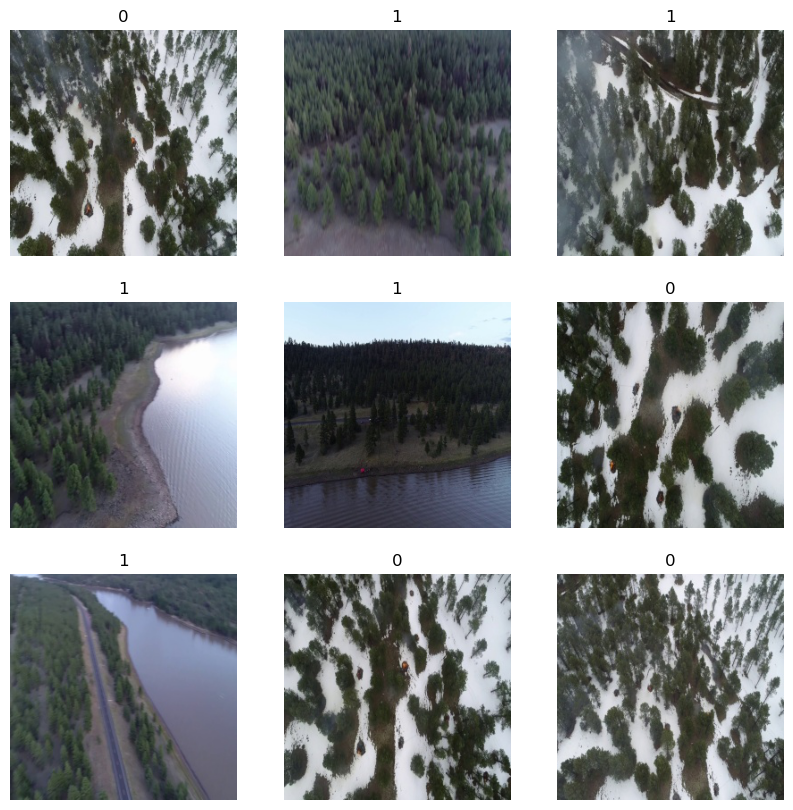

In [9]:
# Get a batch of images and labels from the train_dataset
images, labels = next(train_dataset)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(int(labels[i]))
    plt.axis("off")

plt.show()

The output above shows that the <code>flow_from_directory()</code> method has successfully found the images in the provided directories as well as the two classifications

The code in the cell below is used to output the dictionary that outlines how the classifications are defined numerically:

In [10]:
train_dataset.class_indices

{'Fire': 0, 'No_Fire': 1}

<h4>2.1.3: Constructing, Compiling & Training The ML Model</h4>

The network architecture that will be used for this first investigation has the following structure:

1. Input layer:
    - Has shape (254,254,3), which corresponds to the size of the input datapoints (dataset images) (254x254 px, with 3 colour channels (RGB) per pixel)

2. Convolution layer
    - Consists of 32 3x3 convolutional filters (kernels) that convolve with the layer input to produce 32 featuremaps
    - The featuremaps are used to capture low-level features of the layer input
    - ReLU activation function used

3. Dropout layer:
    - Used to help prevent overfitting
    - Set to 0.4 - this means that a random 40% of input neurons to these layers have their values set to zero. This is meant to be useful in terms of 'forcing' the model to 'capture the important features' of the images that the model is trained on

4. Pooling Layer:
    - Since convolution processes produce a lot of additional data, these pooling layers are used to downsample the resulting featuremaps produced, which can help to increase the efficiency of the network
    - 2x2 pooling layers are used, which effectively means that feature maps become 4x smaller in size

    Layers 2,3,4 are repeated 3 more times, but for each successive repeat, the number of convolution kernels is set to 64,128,128

5. Flatten Layer:
    - Transforms the feature maps produced from the previous layer 'bundle' into a 1D vector

6. Dense Layer 1:
    - Consists of 128 full connected neurons where the activation function used is ReLU

7. Dense Layer 2 (output layer):
    - Consists of a single output neuron where the sigmoid activation function is used
    - The sigmoid activation function is used in conjunction with a single output neuron since a value of 0 or 1 is used, which is neccessary for a binary classification system

In [11]:
# Initialising a CNN
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(254, 254, 3)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

The code below is used to compile the CNN initialised in the cell above:

The ADAM optimisation algorithm is used since it is an improvement over standard stochastic gradient descent (SGD) algorithms in terms of its efficiency and memory usage [2] - The default learing rate of 0.001 is used.

The binary crossentropy loss function is used for this task given that the objective is to develop a binary classification model



In [13]:
# Compiling the CNN
model.compile(
    keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In the cell below:

A 'class weights' dictionary is defined as follows:

1. The keys (0,1) correspond to the values in the classification dictionary outputted at the end of § 2.1.2
2. The values associated with each key are the initial training class weight values calculated in § 2.1.1

The model is fit to the training data:

- 5 training epochs are used - given the size of the dataset, the total train time becomes overly inefficent
- validation data is used to adjust the model parameters at the end of each epoch

In [14]:
# Defining a class weights dictionary using the weights calculated in § 2.1.1 
class_weights = {0: train_fire_weight, 1: train_no_fire_weight}

# Training the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    verbose=1,
    class_weight=class_weights,
    #batch_size=64
)

Epoch 1/5
1969/1969 [==============================] - 807s 410ms/step - loss: 0.0757 - accuracy: 0.9790 - val_loss: 1.0590 - val_accuracy: 0.5215
Epoch 2/5
1969/1969 [==============================] - 808s 411ms/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.7926 - val_accuracy: 0.7394
Epoch 3/5
1969/1969 [==============================] - 802s 407ms/step - loss: 0.0066 - accuracy: 0.9982 - val_loss: 0.9165 - val_accuracy: 0.7333
Epoch 4/5
1969/1969 [==============================] - 800s 406ms/step - loss: 0.0101 - accuracy: 0.9981 - val_loss: 1.0994 - val_accuracy: 0.7109
Epoch 5/5
1969/1969 [==============================] - 803s 408ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 1.1028 - val_accuracy: 0.7416


In [16]:
# Evaluating the model's performance
loss1,accuracy1 = model.evaluate(test_dataset,verbose=1)

539/539 [==============================] - 46s 85ms/step - loss: 2.7734 - accuracy: 0.5881


The above outputs show that the model is severly overfitting to the training data. This is seen most notibly in the disparity between the training losses and validation losses. Furthermore, upon evaluating the model's performance with unseen test data, the fact that the model is overfitted to the train data is very apparent; the model doesnt generalise well to unfamilar data.

<h3>2.2: Binary Classification Using The Original Dataset, But With Augmented Training Data</h3>

In this section, the code used is the exact same as that used in § 2.1. However this time, the training datapoints will have augmentations applied to them live, during training in an effort to increase their veriation

The data augmentation techniques used are passed as parameters to the <code>train_datagen</code> object in the cell below.

In addition to the data normalisation (rescale) used before (in § 2.1), the following data augmentations are also applied:

- Rotation: Images are randomly rotated in a 20° range
- Width and Height Shift: Images are randomly shifted horizontally and vertically by up to 0.1x of their original width and height respectively
- Zoom: Images are randomly zoomed in or out by up 0.2x
- Shearing: Images have a random shearing up to 20° applied to them
- Horizontal Flipping: Images are flipped horizontally
- Colour Space Transformation: Images have their brightness randomly adjusted to a value in the range 0.8-1.2x the original brightness.

In [21]:
# Defining the image data generators
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2, 
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.8, 1.2] 
    )

test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory('Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary',
                                                shuffle=True,
                                                subset='training') 

val_dataset = train_datagen.flow_from_directory('Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary',
                                                subset='validation')

test_dataset = test_datagen.flow_from_directory('Test/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary')

train_dataset.class_indices

Found 31501 images belonging to 2 classes.
Found 7874 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


{'Fire': 0, 'No_Fire': 1}

Same CNN Architecture as § 2.1.3:

In [23]:
# Initialising a CNN
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(254, 254, 3)))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))


model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

Same compilation and fit parameters used:

In [24]:
# Compiling the CNN
model.compile(
    keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [25]:
# Defining a class weights dictionary using the weights calculated in § 2.1.1 
class_weights = {0: train_fire_weight, 1: train_no_fire_weight}

# Training the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    verbose=1,
    class_weight=class_weights,
    #batch_size=64
)

Epoch 1/5
1969/1969 [==============================] - 864s 439ms/step - loss: 0.1708 - accuracy: 0.9429 - val_loss: 1.2499 - val_accuracy: 0.6021
Epoch 2/5
1969/1969 [==============================] - 861s 437ms/step - loss: 0.0786 - accuracy: 0.9708 - val_loss: 2.3827 - val_accuracy: 0.5361
Epoch 3/5
1969/1969 [==============================] - 861s 437ms/step - loss: 0.0556 - accuracy: 0.9807 - val_loss: 1.1066 - val_accuracy: 0.7490
Epoch 4/5
1969/1969 [==============================] - 861s 437ms/step - loss: 0.0440 - accuracy: 0.9856 - val_loss: 1.3088 - val_accuracy: 0.7736
Epoch 5/5
1969/1969 [==============================] - 863s 438ms/step - loss: 0.0376 - accuracy: 0.9876 - val_loss: 1.2981 - val_accuracy: 0.7526


In [26]:
# Evaluating the model's performance
loss1,accuracy1 = model.evaluate(test_dataset,verbose=1)

539/539 [==============================] - 47s 87ms/step - loss: 1.9467 - accuracy: 0.6237


The output above suggests that augmenting the data only provides a 3.56% increase in test accuracy (compared to the model trained with unaugmented training data in § 2.1)

The code cell below will be used to produce plots displaying the following:

1. Training and validation accuracy
2. Training and validation loss

for each epoch of training.

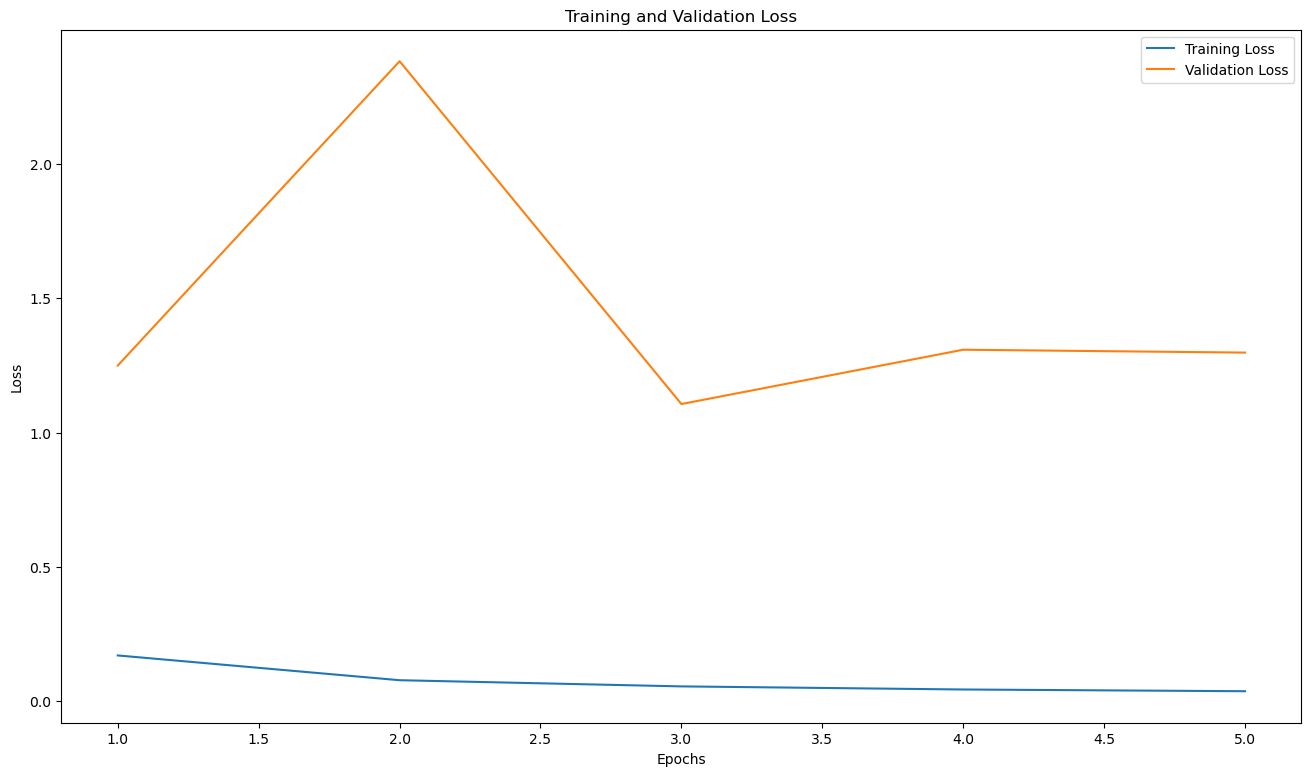

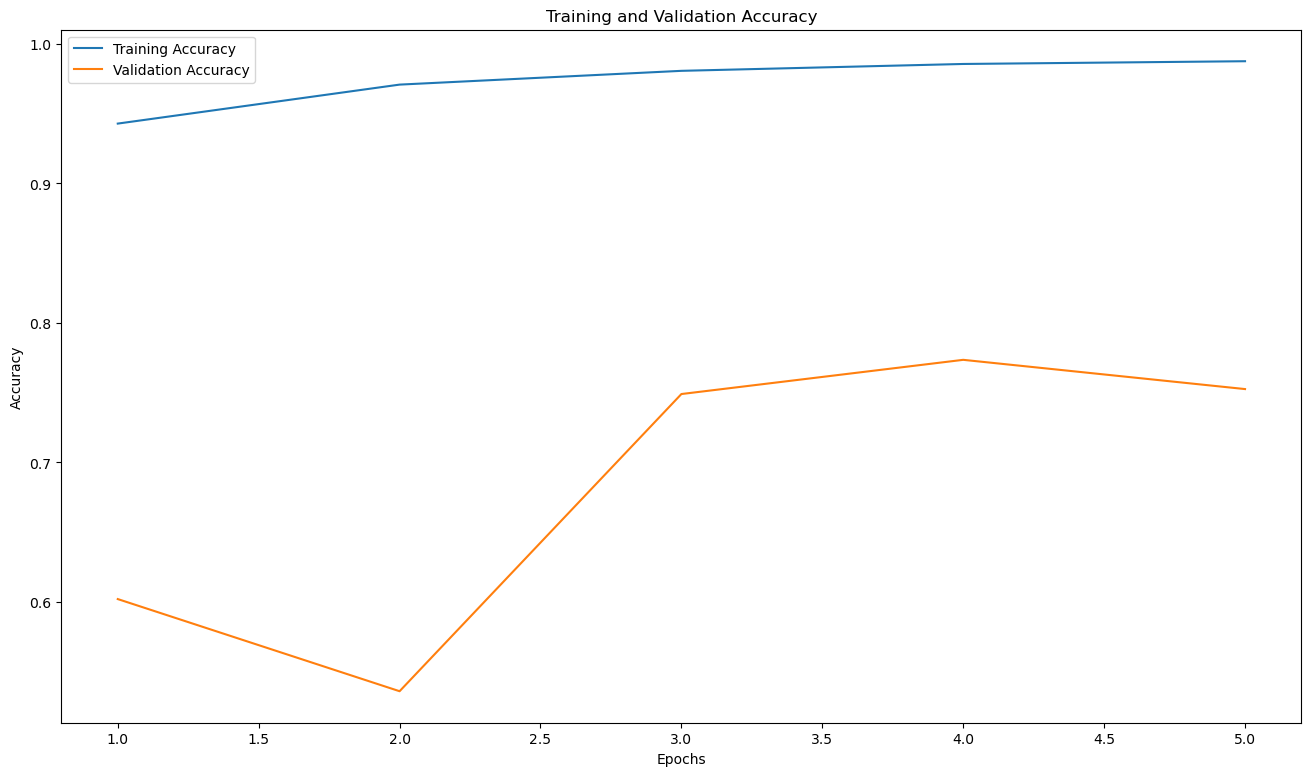

In [30]:
# Extracting loss and accuracy data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and val loss
plt.figure(figsize=(16,9))
plt.plot(np.arange(1,6,1),train_loss,label='Training Loss')
plt.plot(np.arange(1,6,1),val_loss,label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and val accuracy
plt.figure(figsize=(16,9))
plt.plot(np.arange(1,6,1),train_acc,label='Training Accuracy')
plt.plot(np.arange(1,6,1),val_acc,label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The first of the two figures shows that although the model has a relatively low losses during training, when the validity of the model is tested, the loss increases significantly. This appears to be common over all epochs.

This would imply that the model is overfitting to the training data, therefore is unable to generalise well to unseen datapoints. This observation is reflected by the second figure which displays the training and validation accuracies for each epoch, where there is a clear disparity between the two curves.

This point is also highlighted when the model is evaluated with test data (2 code cells up). The test loss and accuracy are significantly higher and lower respectively than the training (and even validation) values obtained.

<h3>2.3: Binary Classification Using Temporally Sampled Data</h3>

As a result to the nature of the datapoints being used for this investigation (each image is a frame from video footage), naturally adjacent images in the dataset are very similar to eachother (ie. there is very little variation between adjacent image(s)). As the training data is derived from a few scenes of video footage, this then means that there are many 'groups' of images that are very similar to eachother, not just the adjacent images.

The fact that the training images used in the previous sections consist of groups of images from the same scenes of video are very similar to eachother, even with data augentation methods applied, the variation of images isnt enough to enable to model to generalise well to different sets of images.

In this section, temporal sampling of the training and test data was performed as a means of introducing some level of variation before any data augmentation is applied (to the training data during training). To perform the temporal sampling, I wrote a python function called <code>CopyImgToDir</code> (found in the <code>CopyImgToDir.ipynb</code> file) that copies images from a directory at a specified sampling interval into a new directory. Given that the video footage that the dataset used (FLAME dataset [3]) was captured at 29 frames per second (FPS), I deemed a sampling interval of 7 frames to be sufficent (1 frame from every 7 corresponds to each sampled image being separated by ~ 0.25s in the video footage).

<h4>2.3.1: Calculating Initial Training Class Weights</h4>

As both the Training: Fire and Training: No Fire images were sampled using the same sampling interval, the ratios of Fire:No Fire training datapoints in both the original training dataset and temporally sampled training dataset are the same. Therefore, the training data class weighs calculated in § 2.1.1 are the same as the training class weights of the sampled data.

In [65]:
# Defining a class weights dictionary using the weights calculated in § 2.1.1 
class_weights = {0: train_fire_weight, 1: train_no_fire_weight}

<h4>2.3.2: Data Processing</h4>

For this investigation, the foundation of the data processing code used is the same as that used in the previous section (§ 2.2), however the image augmentation that will be applied to the images live during model training will be more aggressive. To be specific, the ranges of augmentation parameters have been doubled (eg. rotation range double from 20° to 40°)

In [66]:
# Defining the image data generators, this time with aug param ranges/effects doubled
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.4,
    shear_range=0.4, 
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.6, 1.4] 
    )

test_datagen = ImageDataGenerator(
    rescale=1/255,
    )

train_dataset = train_datagen.flow_from_directory('SampledDataset/BinaryClassification/Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary',
                                                shuffle=True,
                                                subset='training') 

val_dataset = train_datagen.flow_from_directory('SampledDataset/BinaryClassification/Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='binary',
                                                shuffle=True,
                                                subset='validation')

test_dataset = test_datagen.flow_from_directory('SampledDataset/BinaryClassification/Test/',
                                                target_size=(254,254),
                                                batch_size=32,
                                                class_mode='binary')

train_dataset.class_indices

Found 4501 images belonging to 2 classes.
Found 1124 images belonging to 2 classes.
Found 1232 images belonging to 2 classes.


{'Fire': 0, 'No_Fire': 1}

<h4>2.3.3: Constructing, Compiling & Training The ML Model</h4>

In the previous two sections, significant overfitting to the training data was observed. In an attempt to try to reduce overfitting, The network architecture used to train the model is made less complex. Specifically, the number of convolution layers has been reduced from 4 to 3, the number of kernels has been reduced to 16,32,16 for each of the three layers respectively and all but the last dropout layer has been removed (dropout rate also decreased from 0.4 to 0.2) - I am hoping that this last change partially counteracts the effect that simplifying the model would have

This change would also have the effect of increasing the computational efficiency; the training time/epoch should be significantly less than of the previous CNN architecture investigated.

In [67]:
# Initialising a CNN
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(254, 254, 3)))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))

In [68]:
# Compiling the CNN
model.compile(
    keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [69]:
# Training the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    verbose=1,
    class_weight=class_weights,
    #batch_size=32
)

Epoch 1/5
282/282 [==============================] - 62s 216ms/step - loss: 0.6321 - accuracy: 0.6272 - val_loss: 0.5770 - val_accuracy: 0.6815
Epoch 2/5
282/282 [==============================] - 61s 216ms/step - loss: 0.4408 - accuracy: 0.7705 - val_loss: 0.3801 - val_accuracy: 0.8532
Epoch 3/5
282/282 [==============================] - 60s 212ms/step - loss: 0.3589 - accuracy: 0.8429 - val_loss: 0.4192 - val_accuracy: 0.8630
Epoch 4/5
282/282 [==============================] - 60s 212ms/step - loss: 0.3538 - accuracy: 0.8625 - val_loss: 0.4974 - val_accuracy: 0.8203
Epoch 5/5
282/282 [==============================] - 59s 208ms/step - loss: 0.3142 - accuracy: 0.8887 - val_loss: 0.3429 - val_accuracy: 0.8835


In [70]:
# Evaluating the model's performance
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)

39/39 - 3s - loss: 0.6405 - accuracy: 0.6745 - 3s/epoch - 67ms/step


The output above shows that the modifications made for this investigation have resulted in a model that has provided the best test accuracy for a model so far.

The code cell below will be used to produce plots displaying the following:

1. Training and validation accuracy
2. Training and validation loss

for each epoch of training.

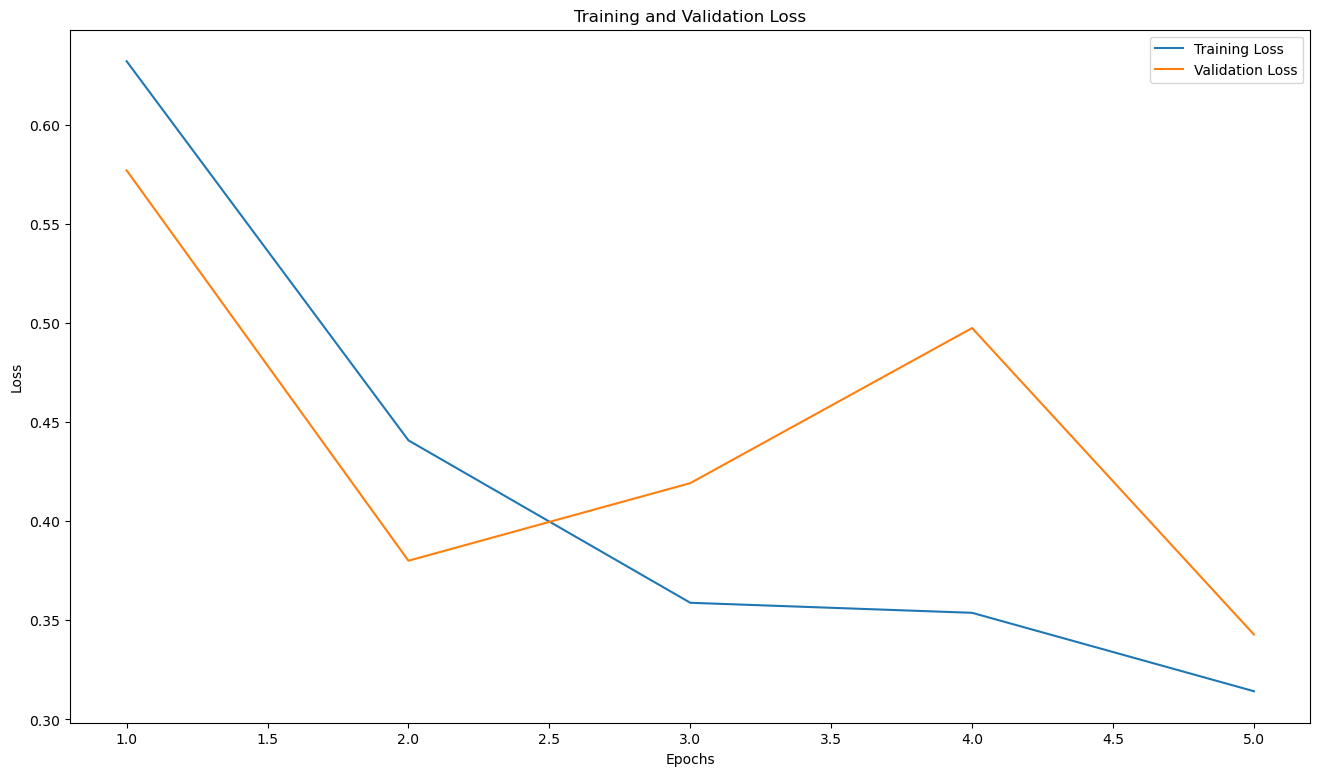

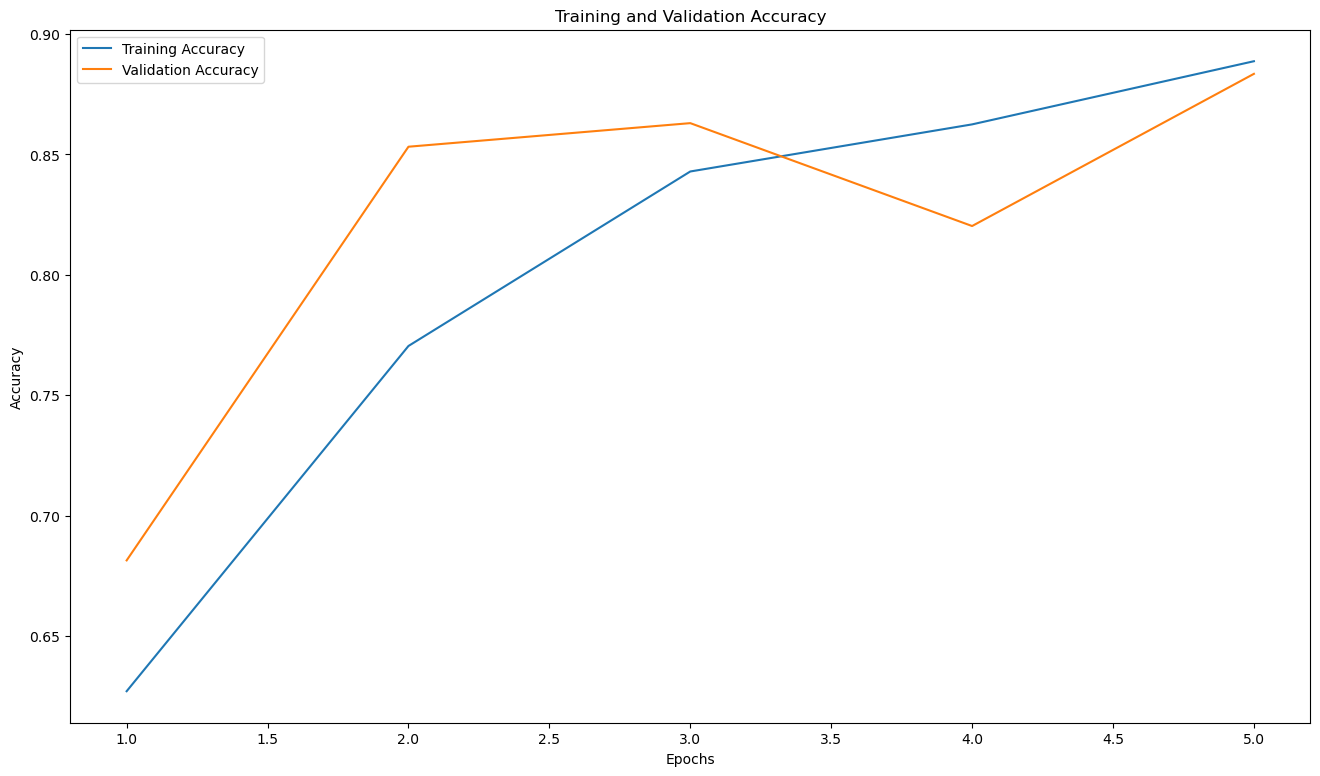

In [71]:
# Extracting loss and accuracy data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and val loss
plt.figure(figsize=(16,9))
plt.plot(np.arange(1,6,1),train_loss,label='Training Loss')
plt.plot(np.arange(1,6,1),val_loss,label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and val accuracy
plt.figure(figsize=(16,9))
plt.plot(np.arange(1,6,1),train_acc,label='Training Accuracy')
plt.plot(np.arange(1,6,1),val_acc,label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

From the figures outputted above, it is clear that towards the end of the training cycle, for both loss and accuracy: the validation and training values are very similar to eachother. This would indicate that the model isnt overfitting to the training data.

<h2>3.0: ML Task 2 - Develop a machine learning classifier that can accurately perform the ternary classification Fire vs No Fire vs Lake</h2>

Building upon the findings from the previous section (§ 2.0), the optimal approach identified was the one used in § 2.3, which involved utilizing agressively augmented, temporally sampled training and test data to train and evaluate a relatively 'simple' CNN architecture for binary classification.

The same methodology will be used to produce a ternary classifier

<h4>3.1.1: Data Processing</h4>

In this investigation, the same data processing that was used in § 2.3.2 is also used here:

In [77]:
# Defining the image data generators
train_datagen = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.4,
    shear_range=0.4, 
    horizontal_flip=True,
    vertical_flip=False,
    brightness_range=[0.6, 1.4] 
    )

test_datagen = ImageDataGenerator(
    rescale=1/255,
    )

train_dataset = train_datagen.flow_from_directory('SampledDataset/TernaryClassification/Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='training') 

val_dataset = train_datagen.flow_from_directory('SampledDataset/TernaryClassification/Training/',
                                                target_size=(254,254),
                                                batch_size=16,
                                                class_mode='categorical',
                                                shuffle=True,
                                                subset='validation')

test_dataset = test_datagen.flow_from_directory('SampledDataset/TernaryClassification/Test/',
                                                target_size=(254,254),
                                                batch_size=32,
                                                class_mode='categorical')

train_dataset.class_indices

Found 4232 images belonging to 3 classes.
Found 1055 images belonging to 3 classes.
Found 1571 images belonging to 3 classes.


{'Fire': 0, 'Lake': 1, 'No_Fire': 2}

<h4>3.1.2: Calculating Initial Training Class Weights</h4>

Given that a ternary classification system is now being modeled, the binary initial training weights cannot be used. The initial training weights must be recalculate for the sampled ternary classification dataset.

In [78]:
# Obtaining the training class indices mapping
train_class_indices = train_dataset.class_indices

# Initialising a dictionary to store the number of images per class
train_class_image_counts = {}

# Iterating over the  training class indices to count the number of images in each class directory
for class_name, class_index in train_class_indices.items():
    class_directory = os.path.join('SampledDataset/TernaryClassification/Training/', class_name)
    class_image_count = len(os.listdir(class_directory))
    train_class_image_counts[class_name] = class_image_count

print("Number of images in each training subset classification directory:", train_class_image_counts)

# Obtaining the test class indices mapping
test_class_indices = test_dataset.class_indices

# Initialising a dictionary to store the number of images per class
test_class_image_counts = {}

# Iterating over the test class indices to count the number of images in each class directory
for class_name, class_index in test_class_indices.items():
    class_directory = os.path.join('SampledDataset/TernaryClassification/Test/', class_name)
    class_image_count = len(os.listdir(class_directory))
    test_class_image_counts[class_name] = class_image_count

print("Number of images in each test subset classification directory:", test_class_image_counts)


Number of images in each training subset classification directory: {'Fire': 3574, 'Lake': 1354, 'No_Fire': 359}
Number of images in each test subset classification directory: {'Fire': 734, 'Lake': 339, 'No_Fire': 498}


In [79]:
# Obtaining values from corresponding keys in class_image_counts
train_fire_count = train_class_image_counts['Fire']
train_no_fire_count = train_class_image_counts['No_Fire']
train_lake_count = train_class_image_counts['Lake']

# Calculating initial weights
train_fire_weight = (train_fire_count + train_no_fire_count + train_lake_count) / (3 * train_fire_count)
train_no_fire_weight = (train_fire_count + train_no_fire_count + train_lake_count) / (3 * train_no_fire_count)
train_lake_weight = (train_fire_count + train_no_fire_count + train_lake_count) / (3 * train_lake_count)

In [80]:
# Creating a dictionary that stores the initial training weights for each class
weights_data = {
    'Classification Subset': ['Training: Fire', 'Training: No Fire', 'Training: Lake'],
    'Initial Weight': [train_fire_weight, train_no_fire_weight, train_lake_weight]
}

# Displaying the info in the dictionary above as a table of data via pandas
df = pd.DataFrame(weights_data)
df

,Classification Subset,Initial Weight
0,Training: Fire,0.493098
1,Training: No Fire,4.909006
2,Training: Lake,1.301576


<h4>3.1.3: Constructing, Compiling & Training The ML Model</h4>

The same network structure that was used in § 2.3.3 is also being used here, except for a couple of modifications that must be made in order to adapt the code for use with a ternary classifier model

Two changes occur, both in the final output layer:

1. 1 output neuron is changed to 3 - for 3 way classifier
2. the sigmoid activation function is replaced with softmax - this is common choice for multi-class classifier models

In [60]:
# Initialising a CNN
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(254, 254, 3)))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
#model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.MaxPooling2D((2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation='relu'))
model.add(keras.layers.Dense(3,activation='softmax'))

The loss function is changed from binary cross-entropy to categorical cross-entropy - once again, is a common choice for multi-class classifier models

In [61]:
# Defining an initial training class weights dictionary
class_weights = {0: train_fire_weight, 1: train_lake_weight, 2: train_no_fire_weight}

# Compiling the CNN
model.compile(
    keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [62]:
# Training the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    verbose=1,
    class_weight=class_weights,
    #batch_size=32
)

Epoch 1/5
265/265 [==============================] - 56s 209ms/step - loss: 0.7420 - accuracy: 0.5907 - val_loss: 0.5984 - val_accuracy: 0.8047
Epoch 2/5
265/265 [==============================] - 56s 210ms/step - loss: 0.5941 - accuracy: 0.7219 - val_loss: 0.5404 - val_accuracy: 0.7716
Epoch 3/5
265/265 [==============================] - 55s 209ms/step - loss: 0.4991 - accuracy: 0.7644 - val_loss: 0.4623 - val_accuracy: 0.8427
Epoch 4/5
265/265 [==============================] - 55s 208ms/step - loss: 0.4353 - accuracy: 0.7897 - val_loss: 0.5288 - val_accuracy: 0.7782
Epoch 5/5
265/265 [==============================] - 54s 205ms/step - loss: 0.4067 - accuracy: 0.8100 - val_loss: 0.5032 - val_accuracy: 0.8275


In [63]:
# Evaluating the model's performance
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=2)

50/50 - 3s - loss: 0.6380 - accuracy: 0.7358 - 3s/epoch - 61ms/step


The code cell below will be used to produce plots displaying the following:

1. Training and validation accuracy
2. Training and validation loss

for each epoch of training.

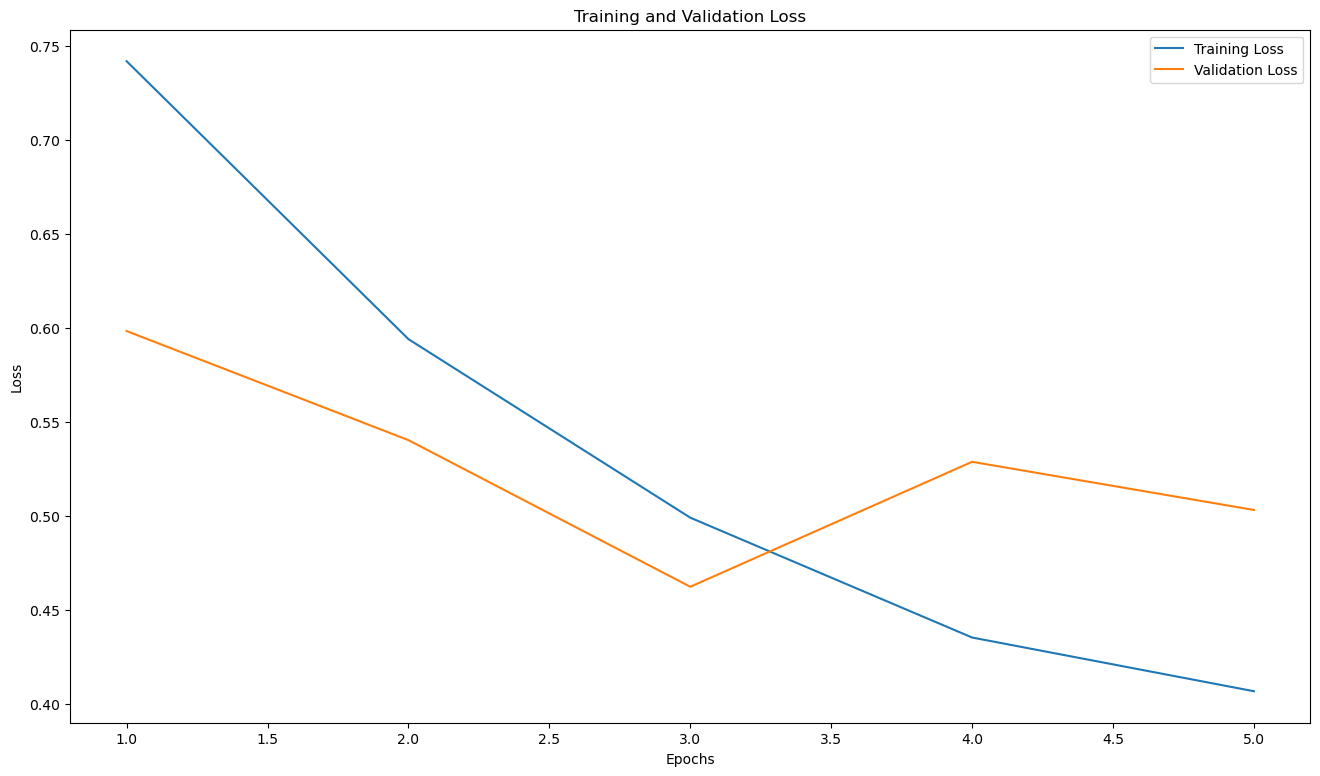

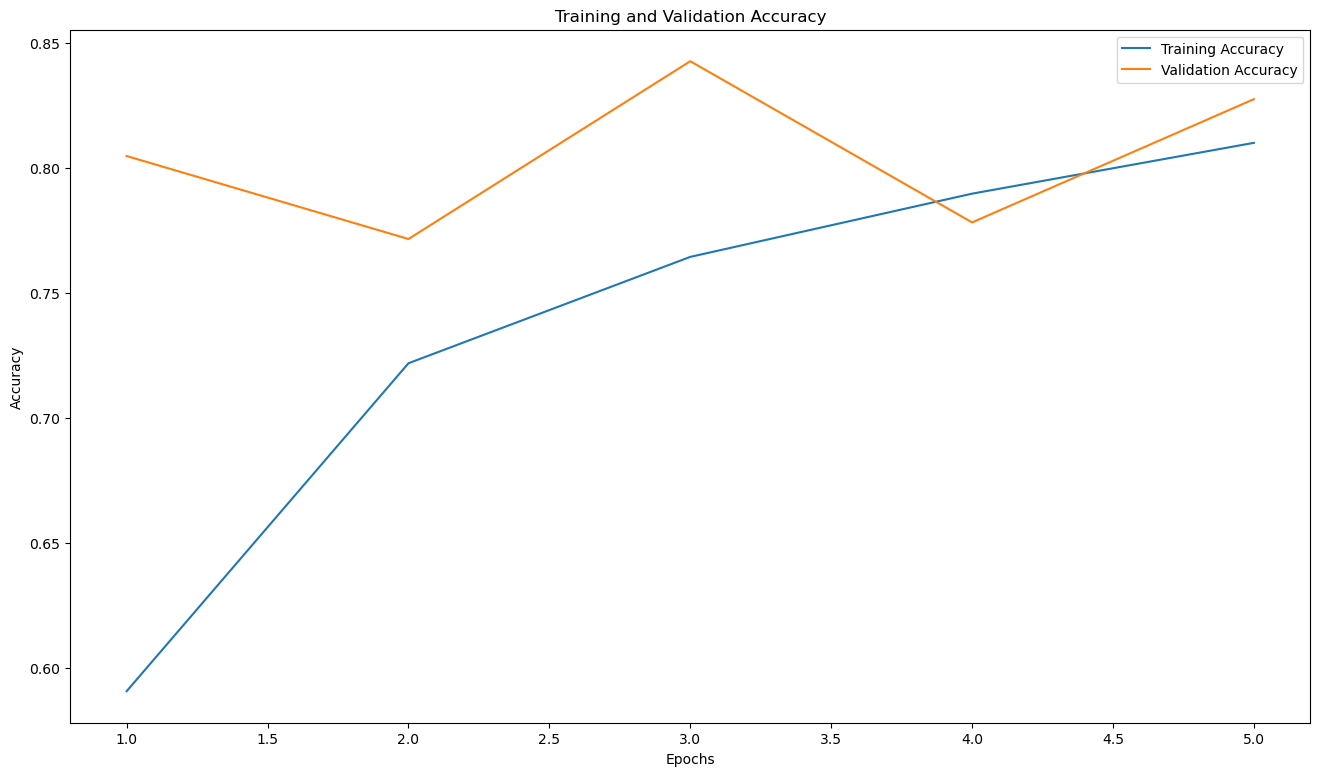

In [64]:
# Extracting loss and accuracy data
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plotting training and val loss
plt.figure(figsize=(16,9))
plt.plot(np.arange(1,6,1),train_loss,label='Training Loss')
plt.plot(np.arange(1,6,1),val_loss,label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and val accuracy
plt.figure(figsize=(16,9))
plt.plot(np.arange(1,6,1),train_acc,label='Training Accuracy')
plt.plot(np.arange(1,6,1),val_acc,label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For the first of the two plots above, the model appears to be overfitting to the training data. However, for the second output, it seems that the model is performing better with the validation data, which is quite unusual. Therefore, there is no conclusive evidence to say that the model is overfitting to the training data.

<h2>References</h2>

[1] K. Singh, “How to Improve Class Imbalance using Class Weights in Machine Learning,” Analytics Vidhya, Oct. 06, 2020. https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

[2] D. P. Kingma and J. Ba, “Adam: A Method for Stochastic Optimization,” arXiv.org, Dec. 22, 2014. https://arxiv.org/abs/1412.6980

[3] Alireza Shamsoshoara, Fatemeh Afghah, Abolfazl Razi, Liming Zheng, Peter Fulé, Erik Blasch, November 19, 2020, "The FLAME dataset: Aerial Imagery Pile burn detection using drones (UAVs)", IEEE Dataport, doi: https://dx.doi.org/10.21227/qad6-r683.